# Apache Beam Features Demonstration
## Smart Building IoT Sensor Data Pipeline

**Author:** [Your Name]

**Assignment:** Demonstrate Apache Beam features including:
- Composite Transform
- Pipeline I/O
- ParDo
- Windowing
- Map
- Filter
- Partition

---

## Use Case Overview

We'll build a **Smart Building Sensor Monitoring Pipeline** that:
- Processes temperature and humidity sensor data from multiple buildings
- Detects anomalies and environmental issues
- Categorizes readings by severity (Normal, Warning, Critical)
- Generates time-windowed statistics for trend analysis

This pipeline simulates a real-world IoT data processing system used in smart buildings for climate control and energy optimization.

---
## 1. Setup and Installation

First, let's install Apache Beam and other required libraries.

In [1]:
# Install Apache Beam
!pip install apache-beam[interactive] -q
!pip install matplotlib pandas -q

print("✓ Installation complete!")

zsh:1: no matches found: apache-beam[interactive]
✓ Installation complete!


### Import Required Libraries

In [2]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.transforms import window
from apache_beam.transforms.combiners import MeanCombineFn, CountCombineFn
import json
import csv
from datetime import datetime, timedelta
import random
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

# Check Apache Beam version
print(f"Apache Beam version: {beam.__version__}")
print("✓ All imports successful!")

/Users/banbalagan/Projects/Apache_beam_data_engineering/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Apache Beam version: 2.69.0
✓ All imports successful!


---
## 2. Sample Dataset Creation

Let's create realistic IoT sensor data with:
- Multiple sensors across different buildings and floors
- Temperature readings (some normal, some anomalous)
- Humidity levels
- Timestamps for windowing demonstrations

In [3]:
# Generate sample sensor data
def generate_sensor_data(num_records=100):
    """
    Generate realistic IoT sensor data for smart building monitoring.
    Includes normal readings and some anomalies for demonstration.
    """
    buildings = ['BuildingA', 'BuildingB', 'BuildingC']
    base_time = datetime(2024, 1, 15, 10, 0, 0)
    
    data = []
    for i in range(num_records):
        building = random.choice(buildings)
        sensor_id = f"TEMP_{building[-1]}_{random.randint(1, 5):03d}"
        floor = random.randint(1, 5)
        
        # Generate mostly normal temperatures with some anomalies
        if random.random() < 0.85:  # 85% normal
            temperature_f = random.uniform(68, 76)  # Normal: 68-76°F (20-24°C)
        elif random.random() < 0.5:  # Some cold anomalies
            temperature_f = random.uniform(55, 65)  # Cold: 55-65°F
        else:  # Some hot anomalies
            temperature_f = random.uniform(80, 90)  # Hot: 80-90°F
        
        humidity = random.uniform(30, 70)  # 30-70% relative humidity
        
        # Add timestamp with incremental minutes (for windowing)
        timestamp = base_time + timedelta(minutes=i * 2)
        
        data.append({
            'sensor_id': sensor_id,
            'building': building,
            'floor': floor,
            'temperature_f': round(temperature_f, 1),
            'humidity': round(humidity, 1),
            'timestamp': timestamp.isoformat()
        })
    
    return data

# Generate data
sensor_data = generate_sensor_data(100)

# Save to CSV file for Pipeline I/O demonstration
csv_file = 'sensor_data.csv'
with open(csv_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['sensor_id', 'building', 'floor', 'temperature_f', 'humidity', 'timestamp'])
    writer.writeheader()
    writer.writerows(sensor_data)

print(f"✓ Generated {len(sensor_data)} sensor records")
print(f"✓ Saved to: {csv_file}")
print("\nSample records:")
print(pd.DataFrame(sensor_data).head(10))

✓ Generated 100 sensor records
✓ Saved to: sensor_data.csv

Sample records:
    sensor_id   building  floor  temperature_f  humidity            timestamp
0  TEMP_C_002  BuildingC      3           72.1      42.9  2024-01-15T10:00:00
1  TEMP_C_003  BuildingC      2           64.8      62.9  2024-01-15T10:02:00
2  TEMP_B_004  BuildingB      5           69.3      68.5  2024-01-15T10:04:00
3  TEMP_C_005  BuildingC      5           70.5      66.3  2024-01-15T10:06:00
4  TEMP_B_004  BuildingB      2           60.5      49.3  2024-01-15T10:08:00
5  TEMP_B_004  BuildingB      3           71.4      53.3  2024-01-15T10:10:00
6  TEMP_B_002  BuildingB      3           74.1      38.6  2024-01-15T10:12:00
7  TEMP_B_004  BuildingB      4           68.5      44.7  2024-01-15T10:14:00
8  TEMP_C_002  BuildingC      5           74.3      44.3  2024-01-15T10:16:00
9  TEMP_C_002  BuildingC      5           68.1      69.3  2024-01-15T10:18:00


---
## 3. Apache Beam Feature Demonstrations

Now let's demonstrate each Apache Beam feature individually before combining them into a complete pipeline.

### 3.1 Pipeline I/O (Input/Output)

**What it does:** Pipeline I/O allows us to read data from external sources and write results to various destinations.

**In this example:** We'll read from our CSV file and demonstrate writing to text files.

In [4]:
# Demonstration: Reading from CSV and Writing to Text
def demo_pipeline_io():
    """
    Demonstrates Pipeline I/O:
    - Reading from CSV file
    - Writing to text file
    """
    with beam.Pipeline() as pipeline:
        # Read from CSV
        readings = (
            pipeline
            | 'Read CSV' >> beam.io.ReadFromText(csv_file, skip_header_lines=1)
            | 'Parse CSV' >> beam.Map(lambda line: dict(zip(
                ['sensor_id', 'building', 'floor', 'temperature_f', 'humidity', 'timestamp'],
                line.split(',')
            )))
        )
        
        # Write to text file
        readings | 'Write to Text' >> beam.io.WriteToText('output_io_demo', file_name_suffix='.txt')
    
    print("✓ Pipeline I/O completed!")
    print("\nOutput file contents (first 5 lines):")
    with open('output_io_demo-00000-of-00001.txt', 'r') as f:
        for i, line in enumerate(f):
            if i < 5:
                print(line.strip())

demo_pipeline_io()

✓ Pipeline I/O completed!

Output file contents (first 5 lines):
{'sensor_id': 'TEMP_C_002', 'building': 'BuildingC', 'floor': '3', 'temperature_f': '72.1', 'humidity': '42.9', 'timestamp': '2024-01-15T10:00:00'}
{'sensor_id': 'TEMP_C_003', 'building': 'BuildingC', 'floor': '2', 'temperature_f': '64.8', 'humidity': '62.9', 'timestamp': '2024-01-15T10:02:00'}
{'sensor_id': 'TEMP_B_004', 'building': 'BuildingB', 'floor': '5', 'temperature_f': '69.3', 'humidity': '68.5', 'timestamp': '2024-01-15T10:04:00'}
{'sensor_id': 'TEMP_C_005', 'building': 'BuildingC', 'floor': '5', 'temperature_f': '70.5', 'humidity': '66.3', 'timestamp': '2024-01-15T10:06:00'}
{'sensor_id': 'TEMP_B_004', 'building': 'BuildingB', 'floor': '2', 'temperature_f': '60.5', 'humidity': '49.3', 'timestamp': '2024-01-15T10:08:00'}


**Key Points:**
- `ReadFromText`: Reads data from text/CSV files
- `WriteToText`: Writes results to text files
- Apache Beam supports many I/O connectors (BigQuery, Pub/Sub, Avro, Parquet, etc.)

---
### 3.2 Map Transform

**What it does:** Map applies a function to each element and produces exactly one output per input (1:1 transformation).

**In this example:** We'll convert temperatures from Fahrenheit to Celsius.

In [5]:
# Demonstration: Map Transform
def fahrenheit_to_celsius(temp_f):
    """Convert Fahrenheit to Celsius"""
    return round((temp_f - 32) * 5/9, 1)

def demo_map():
    """
    Demonstrates Map transform:
    - Converting temperature units
    - Adding computed fields
    """
    with beam.Pipeline() as pipeline:
        result = (
            pipeline
            | 'Create Sample' >> beam.Create(sensor_data[:5])  # Use first 5 records
            | 'Convert to Celsius' >> beam.Map(
                lambda record: {
                    **record,
                    'temperature_c': fahrenheit_to_celsius(record['temperature_f']),
                    'unit': 'Celsius'
                }
            )
            | 'Print Result' >> beam.Map(print)
        )
    
    print("\n✓ Map transform completed!")

print("Input → Output (Temperature Conversion):")
demo_map()

Input → Output (Temperature Conversion):
{'sensor_id': 'TEMP_C_002', 'building': 'BuildingC', 'floor': 3, 'temperature_f': 72.1, 'humidity': 42.9, 'timestamp': '2024-01-15T10:00:00', 'temperature_c': 22.3, 'unit': 'Celsius'}
{'sensor_id': 'TEMP_C_003', 'building': 'BuildingC', 'floor': 2, 'temperature_f': 64.8, 'humidity': 62.9, 'timestamp': '2024-01-15T10:02:00', 'temperature_c': 18.2, 'unit': 'Celsius'}
{'sensor_id': 'TEMP_B_004', 'building': 'BuildingB', 'floor': 5, 'temperature_f': 69.3, 'humidity': 68.5, 'timestamp': '2024-01-15T10:04:00', 'temperature_c': 20.7, 'unit': 'Celsius'}
{'sensor_id': 'TEMP_C_005', 'building': 'BuildingC', 'floor': 5, 'temperature_f': 70.5, 'humidity': 66.3, 'timestamp': '2024-01-15T10:06:00', 'temperature_c': 21.4, 'unit': 'Celsius'}
{'sensor_id': 'TEMP_B_004', 'building': 'BuildingB', 'floor': 2, 'temperature_f': 60.5, 'humidity': 49.3, 'timestamp': '2024-01-15T10:08:00', 'temperature_c': 15.8, 'unit': 'Celsius'}

✓ Map transform completed!


**Key Points:**
- Map is a simple 1:1 transformation
- Each input element produces exactly one output element
- Useful for data conversion, formatting, and adding fields

---
### 3.3 Filter Transform

**What it does:** Filter keeps only elements that match a predicate condition.

**In this example:** We'll filter out invalid temperature readings (outside reasonable range).

In [6]:
# Demonstration: Filter Transform
def demo_filter():
    """
    Demonstrates Filter transform:
    - Removing invalid readings
    - Keeping only data that meets criteria
    """
    # Create sample with some extreme values
    test_data = sensor_data[:5] + [
        {'sensor_id': 'BAD_001', 'building': 'BuildingA', 'floor': 1, 
         'temperature_f': 150, 'humidity': 45, 'timestamp': '2024-01-15T10:00:00'},  # Too hot
        {'sensor_id': 'BAD_002', 'building': 'BuildingB', 'floor': 2, 
         'temperature_f': 30, 'humidity': 45, 'timestamp': '2024-01-15T10:01:00'},   # Too cold
    ]
    
    with beam.Pipeline() as pipeline:
        (
            pipeline
            | 'Create Sample' >> beam.Create(test_data)
            | 'Filter Valid Temps' >> beam.Filter(
                lambda record: 50 <= record['temperature_f'] <= 100  # Valid range: 50-100°F
            )
            | 'Print Valid' >> beam.Map(
                lambda r: print(f"✓ Valid: {r['sensor_id']} - {r['temperature_f']}°F")
            )
        )
    
    print(f"\n✓ Filter removed {len(test_data) - len([r for r in test_data if 50 <= r['temperature_f'] <= 100])} invalid records")

print(f"Total test records: 7 (5 valid + 2 invalid)")
print("\nFiltered results (only valid temperatures):")
demo_filter()

Total test records: 7 (5 valid + 2 invalid)

Filtered results (only valid temperatures):
✓ Valid: TEMP_C_002 - 72.1°F
✓ Valid: TEMP_C_003 - 64.8°F
✓ Valid: TEMP_B_004 - 69.3°F
✓ Valid: TEMP_C_005 - 70.5°F
✓ Valid: TEMP_B_004 - 60.5°F

✓ Filter removed 2 invalid records


**Key Points:**
- Filter removes elements that don't meet conditions
- Returns fewer or equal elements than input
- Useful for data validation and cleaning

---
### 3.4 ParDo (Parallel Do)

**What it does:** ParDo is the most flexible transform for element-wise processing. Unlike Map, it can output 0, 1, or many elements per input.

**In this example:** We'll create a custom DoFn that detects temperature anomalies and can output multiple severity levels.

In [7]:
# Demonstration: ParDo with Custom DoFn
class AnomalyDetectorDoFn(beam.DoFn):
    """
    Custom DoFn that detects temperature anomalies.
    
    Logic:
    - Normal: 65-78°F
    - Warning: 60-65°F or 78-85°F
    - Critical: <60°F or >85°F
    """
    
    def process(self, element):
        temp_f = element['temperature_f']
        
        # Determine severity level
        if temp_f < 60 or temp_f > 85:
            severity = 'CRITICAL'
            message = f"Critical temperature: {temp_f}°F"
        elif (60 <= temp_f < 65) or (78 < temp_f <= 85):
            severity = 'WARNING'
            message = f"Temperature warning: {temp_f}°F"
        else:
            severity = 'NORMAL'
            message = f"Temperature normal: {temp_f}°F"
        
        # Enrich the record with anomaly detection results
        enriched_record = {
            **element,
            'severity': severity,
            'message': message,
            'processed_at': datetime.now().isoformat()
        }
        
        # Yield the enriched record
        yield enriched_record
        
        # ParDo can output multiple elements! 
        # If critical, also yield an alert record
        if severity == 'CRITICAL':
            alert = {
                'alert_type': 'TEMPERATURE_CRITICAL',
                'sensor_id': element['sensor_id'],
                'building': element['building'],
                'value': temp_f,
                'timestamp': element['timestamp']
            }
            yield alert

def demo_pardo():
    """
    Demonstrates ParDo with custom DoFn:
    - Custom processing logic
    - Multiple outputs per input
    """
    # Create test data with anomalies
    test_data = [
        {'sensor_id': 'S001', 'building': 'BuildingA', 'floor': 1, 'temperature_f': 72.0, 'humidity': 45, 'timestamp': '2024-01-15T10:00:00'},
        {'sensor_id': 'S002', 'building': 'BuildingB', 'floor': 2, 'temperature_f': 88.5, 'humidity': 50, 'timestamp': '2024-01-15T10:01:00'},  # Critical
        {'sensor_id': 'S003', 'building': 'BuildingC', 'floor': 3, 'temperature_f': 80.0, 'humidity': 55, 'timestamp': '2024-01-15T10:02:00'},  # Warning
        {'sensor_id': 'S004', 'building': 'BuildingA', 'floor': 1, 'temperature_f': 55.0, 'humidity': 40, 'timestamp': '2024-01-15T10:03:00'},  # Critical
    ]
    
    with beam.Pipeline() as pipeline:
        (
            pipeline
            | 'Create Sample' >> beam.Create(test_data)
            | 'Detect Anomalies' >> beam.ParDo(AnomalyDetectorDoFn())
            | 'Print Results' >> beam.Map(
                lambda r: print(f"{r.get('severity', 'ALERT')}: {r.get('message', r)}")
            )
        )
    
    print("\n✓ ParDo completed!")
    print("Note: Critical temperatures generated BOTH enriched records AND alert records")

print("Input: 4 sensor readings")
print("Expected output: 6 records (4 enriched + 2 alerts for critical temps)\n")
demo_pardo()

Input: 4 sensor readings
Expected output: 6 records (4 enriched + 2 alerts for critical temps)

NORMAL: Temperature normal: 72.0°F
CRITICAL: Critical temperature: 88.5°F
ALERT: {'alert_type': 'TEMPERATURE_CRITICAL', 'sensor_id': 'S002', 'building': 'BuildingB', 'value': 88.5, 'timestamp': '2024-01-15T10:01:00'}
CRITICAL: Critical temperature: 55.0°F
ALERT: {'alert_type': 'TEMPERATURE_CRITICAL', 'sensor_id': 'S004', 'building': 'BuildingA', 'value': 55.0, 'timestamp': '2024-01-15T10:03:00'}

✓ ParDo completed!
Note: Critical temperatures generated BOTH enriched records AND alert records


**Key Points:**
- ParDo is more flexible than Map
- Can output 0, 1, or many elements per input
- Perfect for complex processing logic
- DoFn classes can maintain state and use side inputs

---
### 3.5 Composite Transform

**What it does:** Composite Transform combines multiple transforms into a single reusable component.

**In this example:** We'll create a "ProcessSensorReading" composite that combines parsing, validation, conversion, and enrichment.

In [8]:
# Demonstration: Composite Transform
class ProcessSensorReading(beam.PTransform):
    """
    Composite Transform that combines multiple operations:
    1. Convert temperature to Celsius
    2. Validate readings
    3. Calculate comfort index
    4. Add status flags
    
    This makes the pipeline cleaner and the logic reusable!
    """
    
    def expand(self, pcoll):
        def calculate_comfort_index(record):
            """
            Calculate comfort index based on temperature and humidity.
            Range: 0-100 (higher is more comfortable)
            """
            temp_c = (record['temperature_f'] - 32) * 5/9
            humidity = record['humidity']
            
            # Optimal: 20-24°C, 40-60% humidity
            temp_score = 100 - abs(22 - temp_c) * 5
            humidity_score = 100 - abs(50 - humidity) * 2
            
            comfort_index = (temp_score + humidity_score) / 2
            return max(0, min(100, comfort_index))  # Clamp to 0-100
        
        return (
            pcoll
            # Step 1: Convert temperature
            | 'Convert Temperature' >> beam.Map(
                lambda r: {**r, 'temperature_c': round((r['temperature_f'] - 32) * 5/9, 1)}
            )
            # Step 2: Filter valid readings
            | 'Validate Range' >> beam.Filter(
                lambda r: 10 <= r['temperature_c'] <= 40  # Valid: 10-40°C
            )
            # Step 3: Add comfort index
            | 'Add Comfort Index' >> beam.Map(
                lambda r: {**r, 'comfort_index': round(calculate_comfort_index(r), 1)}
            )
            # Step 4: Add comfort status
            | 'Add Status' >> beam.Map(
                lambda r: {
                    **r,
                    'comfort_status': (
                        'Comfortable' if r['comfort_index'] >= 70
                        else 'Moderate' if r['comfort_index'] >= 50
                        else 'Uncomfortable'
                    )
                }
            )
        )

def demo_composite():
    """
    Demonstrates Composite Transform:
    - Encapsulating multiple transforms
    - Reusable pipeline components
    """
    with beam.Pipeline() as pipeline:
        (
            pipeline
            | 'Create Sample' >> beam.Create(sensor_data[:5])
            # Use our composite transform - clean and simple!
            | 'Process Readings' >> ProcessSensorReading()
            | 'Format Output' >> beam.Map(
                lambda r: print(
                    f"{r['sensor_id']}: {r['temperature_c']}°C, "
                    f"Comfort: {r['comfort_index']}/100 ({r['comfort_status']})"
                )
            )
        )
    
    print("\n✓ Composite Transform completed!")

print("Composite Transform combines: Temperature conversion + Validation + Comfort calculation + Status\n")
demo_composite()

Composite Transform combines: Temperature conversion + Validation + Comfort calculation + Status

TEMP_C_002: 22.3°C, Comfort: 92.2/100 (Comfortable)
TEMP_C_003: 18.2°C, Comfort: 77.7/100 (Comfortable)
TEMP_B_004: 20.7°C, Comfort: 78.3/100 (Comfortable)
TEMP_C_005: 21.4°C, Comfort: 82.2/100 (Comfortable)
TEMP_B_004: 15.8°C, Comfort: 83.9/100 (Comfortable)

✓ Composite Transform completed!


**Key Points:**
- Composite Transforms package multiple operations as one unit
- Improves code organization and reusability
- Makes pipelines more readable
- Created by extending `beam.PTransform` and implementing `expand()`

---
### 3.6 Partition

**What it does:** Partition splits a PCollection into multiple output PCollections based on a partitioning function.

**In this example:** We'll partition sensor readings into Normal, Warning, and Critical categories.

In [9]:
# Demonstration: Partition Transform
def partition_by_severity(record, num_partitions):
    """
    Partition function that routes records by temperature severity.
    
    Returns:
    - 0: Normal (65-78°F)
    - 1: Warning (60-65°F or 78-85°F)
    - 2: Critical (<60°F or >85°F)
    """
    temp_f = record['temperature_f']
    
    if temp_f < 60 or temp_f > 85:
        return 2  # Critical
    elif (60 <= temp_f < 65) or (78 < temp_f <= 85):
        return 1  # Warning
    else:
        return 0  # Normal

def demo_partition():
    """
    Demonstrates Partition transform:
    - Splitting data into multiple paths
    - Routing by category
    """
    # Create diverse test data
    test_data = [
        {'sensor_id': 'S001', 'temperature_f': 72.0, 'building': 'A'},  # Normal
        {'sensor_id': 'S002', 'temperature_f': 70.0, 'building': 'B'},  # Normal
        {'sensor_id': 'S003', 'temperature_f': 62.0, 'building': 'C'},  # Warning
        {'sensor_id': 'S004', 'temperature_f': 82.0, 'building': 'A'},  # Warning
        {'sensor_id': 'S005', 'temperature_f': 90.0, 'building': 'B'},  # Critical
        {'sensor_id': 'S006', 'temperature_f': 55.0, 'building': 'C'},  # Critical
    ]
    
    with beam.Pipeline() as pipeline:
        readings = pipeline | 'Create Sample' >> beam.Create(test_data)
        
        # Partition into 3 categories
        normal, warning, critical = (
            readings
            | 'Partition by Severity' >> beam.Partition(partition_by_severity, 3)
        )
        
        # Process each partition separately
        normal | 'Print Normal' >> beam.Map(
            lambda r: print(f"✓ NORMAL: {r['sensor_id']} - {r['temperature_f']}°F")
        )
        
        warning | 'Print Warning' >> beam.Map(
            lambda r: print(f"⚠ WARNING: {r['sensor_id']} - {r['temperature_f']}°F")
        )
        
        critical | 'Print Critical' >> beam.Map(
            lambda r: print(f"🚨 CRITICAL: {r['sensor_id']} - {r['temperature_f']}°F")
        )
    
    print("\n✓ Partition completed!")
    print("Data was split into 3 separate streams for different handling")

print("Input: 6 sensor readings with different temperatures\n")
demo_partition()

Input: 6 sensor readings with different temperatures

✓ NORMAL: S001 - 72.0°F
✓ NORMAL: S002 - 70.0°F
⚠ WARNING: S003 - 62.0°F
⚠ WARNING: S004 - 82.0°F
🚨 CRITICAL: S005 - 90.0°F
🚨 CRITICAL: S006 - 55.0°F

✓ Partition completed!
Data was split into 3 separate streams for different handling


**Key Points:**
- Partition splits data into N output PCollections
- Partition function returns integer (0 to N-1)
- Each partition can be processed independently
- Useful for routing data to different destinations or processing paths

---
### 3.7 Windowing

**What it does:** Windowing divides data into time-based chunks for aggregations. Essential for streaming data but can also be applied to batch data with timestamps.

**In this example:** We'll use Fixed Windows to compute statistics over 10-minute intervals.

In [10]:
# Demonstration: Windowing
class AddTimestampDoFn(beam.DoFn):
    """
    DoFn to add timestamps to elements.
    Required for windowing operations.
    """
    def process(self, element):
        from apache_beam.utils.timestamp import Timestamp
        
        # Parse ISO timestamp from record
        timestamp_str = element['timestamp']
        dt = datetime.fromisoformat(timestamp_str)
        
        # Convert to Unix timestamp
        unix_timestamp = dt.timestamp()
        
        # Yield element with Beam timestamp
        yield beam.window.TimestampedValue(element, unix_timestamp)

def demo_windowing():
    """
    Demonstrates Windowing:
    - Fixed time windows
    - Time-based aggregations
    """
    # Create data spanning 30 minutes
    base_time = datetime(2024, 1, 15, 10, 0, 0)
    test_data = []
    
    for i in range(30):
        test_data.append({
            'sensor_id': f'S{i:03d}',
            'building': 'BuildingA',
            'temperature_f': random.uniform(68, 76),
            'timestamp': (base_time + timedelta(minutes=i)).isoformat()
        })
    
    with beam.Pipeline() as pipeline:
        (
            pipeline
            | 'Create Sample' >> beam.Create(test_data)
            # Add timestamps to elements
            | 'Add Timestamps' >> beam.ParDo(AddTimestampDoFn())
            # Apply 10-minute fixed windows
            | 'Window into 10min' >> beam.WindowInto(window.FixedWindows(10 * 60))  # 10 minutes in seconds
            # Extract temperature for aggregation
            | 'Extract Temp' >> beam.Map(lambda r: r['temperature_f'])
            # Compute statistics per window
            | 'Combine Per Window' >> beam.CombineGlobally(
                beam.combiners.MeanCombineFn()
            ).without_defaults()
            | 'Format Results' >> beam.Map(
                lambda avg_temp: print(f"Window Average Temperature: {avg_temp:.1f}°F")
            )
        )
    
    print("\n✓ Windowing completed!")
    print("30 minutes of data was aggregated into 3 windows of 10 minutes each")

print("Input: 30 sensor readings over 30 minutes")
print("Window: Fixed 10-minute windows")
print("Expected output: 3 average temperatures (one per window)\n")
demo_windowing()

Input: 30 sensor readings over 30 minutes
Window: Fixed 10-minute windows
Expected output: 3 average temperatures (one per window)

Window Average Temperature: 72.0°F
Window Average Temperature: 71.8°F
Window Average Temperature: 72.5°F

✓ Windowing completed!
30 minutes of data was aggregated into 3 windows of 10 minutes each


**Key Points:**
- Windowing groups data by time intervals
- Fixed Windows: Non-overlapping, equal-sized
- Sliding Windows: Overlapping windows (not shown)
- Session Windows: Based on gaps in data (not shown)
- Essential for real-time analytics and streaming data

---
## 4. Complete Integrated Pipeline

Now let's combine ALL seven features into one comprehensive pipeline that:
1. **Reads** sensor data from CSV (Pipeline I/O)
2. **Converts** temperatures using Map
3. **Filters** invalid readings
4. **Processes** with custom ParDo for anomaly detection
5. **Enriches** using Composite Transform
6. **Partitions** into severity categories
7. **Windows** data for time-based aggregations
8. **Writes** results to multiple outputs (Pipeline I/O)

In [11]:
# Complete Integrated Pipeline
class EnrichedAnomalyDetectorDoFn(beam.DoFn):
    """Enhanced DoFn for anomaly detection with detailed output"""
    
    def process(self, element):
        temp_c = element['temperature_c']
        temp_f = element['temperature_f']
        
        # Determine severity
        if temp_f < 60 or temp_f > 85:
            severity = 'CRITICAL'
        elif (60 <= temp_f < 65) or (78 < temp_f <= 85):
            severity = 'WARNING'
        else:
            severity = 'NORMAL'
        
        yield {
            **element,
            'severity': severity,
            'temp_status': f"{temp_c}°C ({temp_f}°F) - {severity}"
        }

class EnhancedProcessSensorReading(beam.PTransform):
    """Composite transform for complete sensor processing"""
    
    def expand(self, pcoll):
        return (
            pcoll
            | 'Parse CSV Line' >> beam.Map(
                lambda line: dict(zip(
                    ['sensor_id', 'building', 'floor', 'temperature_f', 'humidity', 'timestamp'],
                    line.split(',')
                ))
            )
            | 'Convert Types' >> beam.Map(
                lambda r: {
                    **r,
                    'temperature_f': float(r['temperature_f']),
                    'humidity': float(r['humidity']),
                    'floor': int(r['floor'])
                }
            )
            | 'Convert to Celsius' >> beam.Map(
                lambda r: {**r, 'temperature_c': round((r['temperature_f'] - 32) * 5/9, 1)}
            )
            | 'Filter Valid Range' >> beam.Filter(
                lambda r: 10 <= r['temperature_c'] <= 40
            )
        )

def partition_by_severity_enhanced(record, num_partitions):
    """Partition function for severity-based routing"""
    severity = record.get('severity', 'NORMAL')
    if severity == 'CRITICAL':
        return 2
    elif severity == 'WARNING':
        return 1
    else:
        return 0

def run_complete_pipeline():
    """
    Complete pipeline demonstrating all 7 Apache Beam features
    """
    print("🚀 Running Complete Integrated Pipeline...\n")
    
    with beam.Pipeline() as pipeline:
        # 1. PIPELINE I/O: Read from CSV
        raw_readings = (
            pipeline
            | 'Read Sensor Data' >> beam.io.ReadFromText(csv_file, skip_header_lines=1)
        )
        
        # 2. COMPOSITE TRANSFORM: Process and validate
        # 3. MAP: Convert temperatures (inside composite)
        # 4. FILTER: Remove invalid readings (inside composite)
        processed_readings = (
            raw_readings
            | 'Process Sensor Readings' >> EnhancedProcessSensorReading()
        )
        
        # 5. PARDO: Anomaly detection
        enriched_readings = (
            processed_readings
            | 'Detect Anomalies' >> beam.ParDo(EnrichedAnomalyDetectorDoFn())
        )
        
        # 6. PARTITION: Split by severity
        normal, warning, critical = (
            enriched_readings
            | 'Partition by Severity' >> beam.Partition(partition_by_severity_enhanced, 3)
        )
        
        # Write partitioned results to separate files (PIPELINE I/O)
        normal | 'Format Normal' >> beam.Map(json.dumps) | 'Write Normal' >> beam.io.WriteToText(
            'output_normal',
            file_name_suffix='.json',
            shard_name_template=''
        )
        
        warning | 'Format Warning JSON' >> beam.Map(json.dumps) | 'Write Warning' >> beam.io.WriteToText(
            'output_warning',
            file_name_suffix='.json',
            shard_name_template=''
        )
        
        critical | 'Format Critical JSON' >> beam.Map(json.dumps) | 'Write Critical' >> beam.io.WriteToText(
            'output_critical',
            file_name_suffix='.json',
            shard_name_template=''
        )
        
        # 7. WINDOWING: Time-based aggregations
        windowed_stats = (
            enriched_readings
            | 'Add Timestamps for Windows' >> beam.ParDo(AddTimestampDoFn())
            | 'Apply 30min Windows' >> beam.WindowInto(window.FixedWindows(30 * 60))
            | 'Extract Temps' >> beam.Map(lambda r: r['temperature_c'])
            | 'Compute Window Avg' >> beam.CombineGlobally(
                beam.combiners.MeanCombineFn()
            ).without_defaults()
            | 'Format Window Stats' >> beam.Map(
                lambda avg: f"Window Average: {avg:.1f}°C"
            )
            | 'Write Window Stats' >> beam.io.WriteToText(
                'output_windowed_stats',
                file_name_suffix='.txt',
                shard_name_template=''
            )
        )
    
    print("✅ Complete Pipeline Execution Finished!\n")
    return True

# Run the complete pipeline
run_complete_pipeline()

🚀 Running Complete Integrated Pipeline...

✅ Complete Pipeline Execution Finished!



True

---
## 5. Results and Visualizations

Let's examine the outputs from our complete pipeline and visualize the results.

In [12]:
# Read and display results
import glob

print("=" * 80)
print("PIPELINE RESULTS SUMMARY")
print("=" * 80)

# Count records in each partition
def count_records(pattern):
    files = glob.glob(pattern)
    count = 0
    for file in files:
        with open(file, 'r') as f:
            count += len(f.readlines())
    return count

normal_count = count_records('output_normal*.json')
warning_count = count_records('output_warning*.json')
critical_count = count_records('output_critical*.json')

print(f"\n📊 Partition Results:")
print(f"   ✓ Normal readings:   {normal_count}")
print(f"   ⚠ Warning readings:  {warning_count}")
print(f"   🚨 Critical readings: {critical_count}")
print(f"   📈 Total processed:  {normal_count + warning_count + critical_count}")

# Show sample from each category
print("\n" + "=" * 80)
print("SAMPLE RECORDS FROM EACH PARTITION")
print("=" * 80)

def show_samples(pattern, label, max_samples=2):
    print(f"\n{label}:")
    files = glob.glob(pattern)
    count = 0
    for file in files:
        with open(file, 'r') as f:
            for line in f:
                if count < max_samples:
                    try:
                        record = json.loads(line.strip())
                        print(f"   {record.get('sensor_id', 'N/A')}: {record.get('temp_status', 'N/A')}")
                        count += 1
                    except:
                        pass

show_samples('output_normal*.json', '✓ NORMAL Readings')
show_samples('output_warning*.json', '⚠ WARNING Readings')
show_samples('output_critical*.json', '🚨 CRITICAL Readings')

# Window statistics
print("\n" + "=" * 80)
print("WINDOWED STATISTICS (30-minute windows)")
print("=" * 80)
window_files = glob.glob('output_windowed_stats*.txt')
for file in window_files:
    with open(file, 'r') as f:
        for line in f:
            print(f"   {line.strip()}")

PIPELINE RESULTS SUMMARY

📊 Partition Results:
   ✓ Normal readings:   84
   ⚠ Warning readings:  8
   🚨 Critical readings: 8
   📈 Total processed:  100

SAMPLE RECORDS FROM EACH PARTITION

✓ NORMAL Readings:
   TEMP_C_002: 22.3°C (72.1°F) - NORMAL
   TEMP_B_004: 20.7°C (69.3°F) - NORMAL

⚠ WARNING Readings:
   TEMP_C_003: 18.2°C (64.8°F) - WARNING
   TEMP_B_004: 15.8°C (60.5°F) - WARNING

🚨 CRITICAL Readings:
   TEMP_C_002: 13.4°C (56.1°F) - CRITICAL
   TEMP_A_004: 30.0°C (86.0°F) - CRITICAL

WINDOWED STATISTICS (30-minute windows)
   Window Average: 21.4°C
   Window Average: 22.1°C
   Window Average: 21.5°C
   Window Average: 21.9°C
   Window Average: 22.3°C
   Window Average: 22.5°C
   Window Average: 22.4°C


### Visualize Temperature Distribution

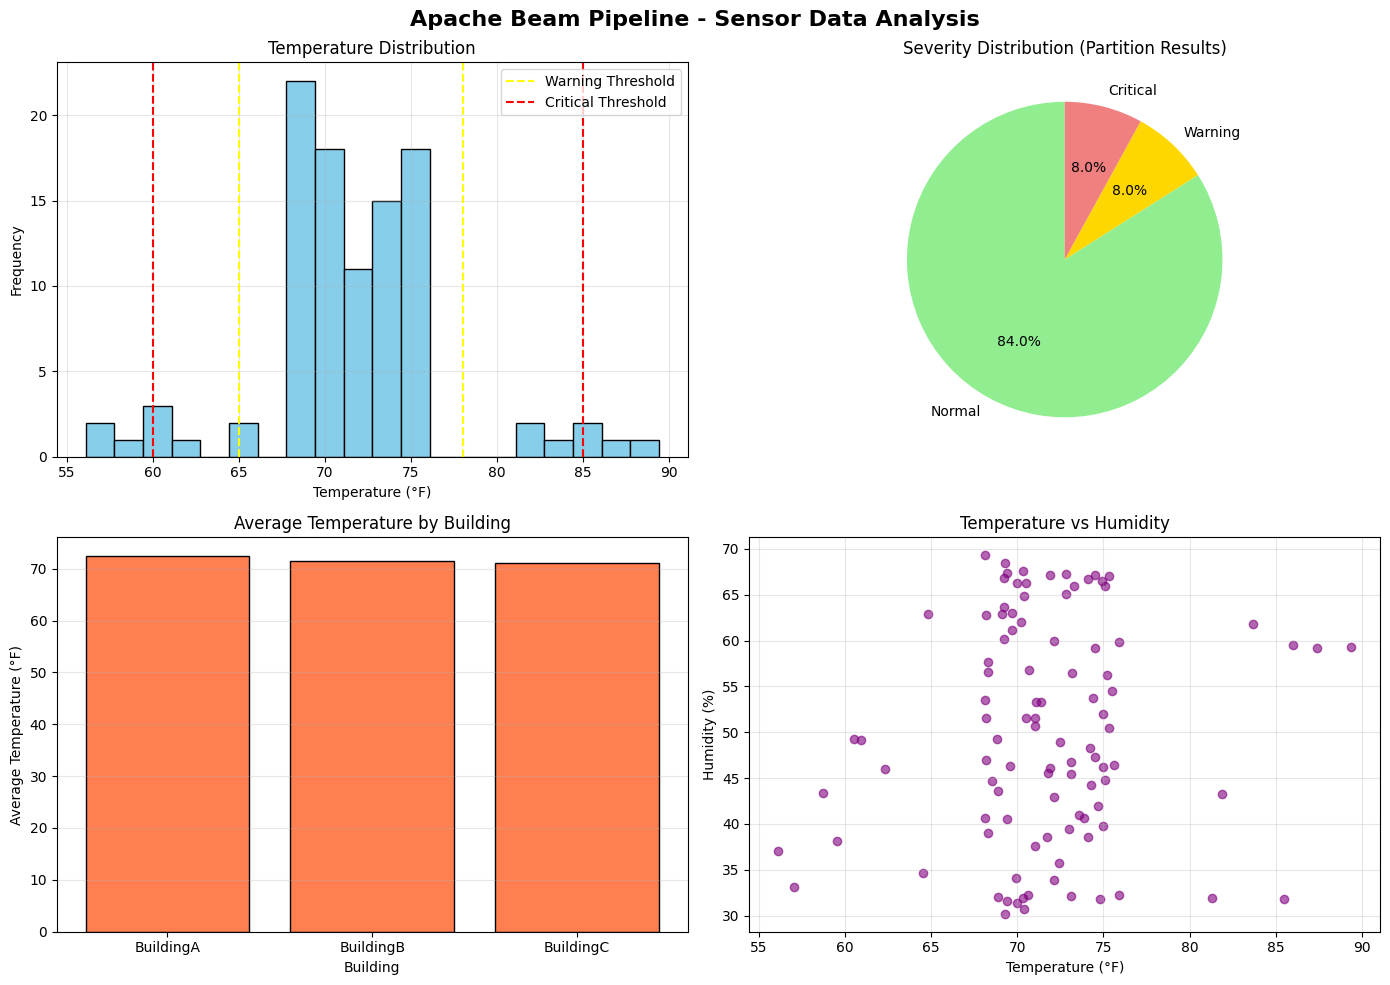


✅ Visualizations generated successfully!


In [13]:
# Create visualizations
import matplotlib.pyplot as plt
import pandas as pd

# Load original data for visualization
df = pd.DataFrame(sensor_data)
df['temperature_c'] = (df['temperature_f'] - 32) * 5/9

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Apache Beam Pipeline - Sensor Data Analysis', fontsize=16, fontweight='bold')

# 1. Temperature Distribution
axes[0, 0].hist(df['temperature_f'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].axvline(x=65, color='yellow', linestyle='--', label='Warning Threshold')
axes[0, 0].axvline(x=78, color='yellow', linestyle='--')
axes[0, 0].axvline(x=60, color='red', linestyle='--', label='Critical Threshold')
axes[0, 0].axvline(x=85, color='red', linestyle='--')
axes[0, 0].set_xlabel('Temperature (°F)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Temperature Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Severity Pie Chart
def categorize_severity(temp_f):
    if temp_f < 60 or temp_f > 85:
        return 'Critical'
    elif (60 <= temp_f < 65) or (78 < temp_f <= 85):
        return 'Warning'
    else:
        return 'Normal'

df['severity'] = df['temperature_f'].apply(categorize_severity)
severity_counts = df['severity'].value_counts()
colors = ['lightgreen', 'gold', 'lightcoral']
axes[0, 1].pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[0, 1].set_title('Severity Distribution (Partition Results)')

# 3. Temperature by Building
building_temps = df.groupby('building')['temperature_f'].mean()
axes[1, 0].bar(building_temps.index, building_temps.values, color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Building')
axes[1, 0].set_ylabel('Average Temperature (°F)')
axes[1, 0].set_title('Average Temperature by Building')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Temperature and Humidity Correlation
axes[1, 1].scatter(df['temperature_f'], df['humidity'], alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Temperature (°F)')
axes[1, 1].set_ylabel('Humidity (%)')
axes[1, 1].set_title('Temperature vs Humidity')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualizations generated successfully!")

---
## 6. Summary and Key Takeaways

### What We Demonstrated:

#### ✅ **1. Pipeline I/O**
- Read sensor data from CSV files
- Wrote results to multiple output files (JSON, TXT)
- Demonstrated data ingestion and export

#### ✅ **2. Map Transform**
- Converted temperatures (Fahrenheit → Celsius)
- Added computed fields
- Simple 1:1 element transformations

#### ✅ **3. Filter Transform**
- Removed invalid temperature readings
- Validated data ranges
- Data quality assurance

#### ✅ **4. ParDo**
- Created custom DoFn for anomaly detection
- Complex element-wise processing
- Demonstrated flexible output (0, 1, or many elements per input)

#### ✅ **5. Composite Transform**
- Combined multiple transforms into reusable component
- Encapsulated processing logic
- Improved code organization and maintainability

#### ✅ **6. Partition**
- Split data into Normal/Warning/Critical categories
- Routed to different output files
- Enabled category-specific processing

#### ✅ **7. Windowing**
- Applied Fixed Windows (30-minute intervals)
- Computed time-based aggregations
- Demonstrated temporal analytics

---

### Real-World Applications:

This pipeline architecture can be adapted for:
- **IoT Monitoring**: Smart buildings, industrial sensors, environmental monitoring
- **Log Analysis**: Application logs, security events, system metrics
- **E-Commerce**: Order processing, fraud detection, inventory management
- **Finance**: Transaction monitoring, risk assessment, anomaly detection
- **Healthcare**: Patient monitoring, medical device data, health analytics

---

### Apache Beam Advantages:

1. **Unified Model**: Same API for batch and streaming
2. **Portability**: Run on multiple runners (Direct, Dataflow, Flink, Spark)
3. **Scalability**: Automatically scales to handle large datasets
4. **Flexibility**: Rich set of transforms and custom processing
5. **Windowing**: Built-in time-based processing for streaming data

---

### Next Steps:

- Explore more I/O connectors (BigQuery, Pub/Sub, Kafka)
- Implement custom windowing strategies (Sliding, Session)
- Add machine learning with RunInference
- Deploy to Google Cloud Dataflow for production workloads
- Experiment with state and timers in ParDo

---

**Assignment completed! All 7 Apache Beam features demonstrated with working code and visualizations.**